# MNIST

## 데이터 불러오기

In [25]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [26]:
X,y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

# MNIST 데이터는 70000개의 data와 784개의 특성을 가지고 있다.

(70000, 784)
(70000,)


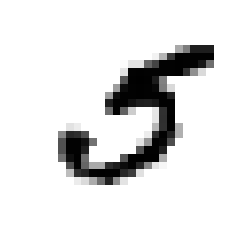

In [96]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
interpolation= "nearest")
plt.axis("off")
plt.show()

In [28]:
y[36000]

5.0

In [29]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [30]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# MNIST 데이터셋은 앞의 6만개가 train set, 뒤의 1만개는 test set으로 이미 구성되어 있다.
# train set과 test set에 각각의 숫자들이 고루 분포하게 섞어준다.
# 특정 숫자만 많다면 좋은 모델이 나오지 않을 것이다.

## 이진 분류기

In [31]:
# 5와 5가 아닌 것들을 분류하는 분류기

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [32]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

# max_iter = 5 라는 의미는 train set을 5번 반복해서 학습하겠다는 의미이다.
# SGDClassifier는 train set을 1번 전체(epoch) 학습하면 train set을 다시 섞습니다. (p.126 주석)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
# data set을 3개의 폴드로 나눕니다.

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9649
0.9396
0.96645


In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring= "accuracy")

array([0.9649 , 0.9396 , 0.96645])

In [36]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype = bool)
    
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")
# cv는 교차검증 시 data를 나누는 갯수

array([0.9085 , 0.9105 , 0.90995])

## 오차 행렬 (Confusion Matrix)

클래스 A의 샘플이 클래스 B로 분류된 횟수를 세어 matrix로 표현한 것.

ex) 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다.

In [37]:
# ??? 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 합니다.

In [38]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [39]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53216,  1363],
       [ 1218,  4203]])

오차 행렬의 첫번째 행은 5가 아닌 이미지를 예측한 결과를 나타내고 두번째 행은 5인 이미지를 예측한 결과를 나타냅니다.

53137개의 5가아닌 이미지를 5가 아니라고 예측했고 ( TN ), 1442개의 5가아닌 이미지를 5라고 잘못 예측했습니다( FP ).

1176개의 5인 이미지를 5가 아니라고 잘못 예측했고 ( FN ), 4245개의 5인 이미지를 5라고 예측했습니다( TP ).

###### precision (정밀도 ) = TP / ( TP+FP)
###### recall (재현율) = TP / ( TP+FN )


## 정밀도와 재현율

In [40]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print()
print(recall_score(y_train_5,y_train_pred))

0.7551203736974488

0.7753182069728832


In [41]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5,y_train_pred))

0.7650860107399654


In [42]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

# 결정 함수를 사용해 값을 내고, 이 값이 임계값보다 높으면 true로 예측한다.

[141035.52246961]


In [45]:
threshold = 0
# 임계값, 임계값이 높으면 예측을 더 까다롭게 한다.
# 정밀도는 높아지나 재현율이 낮아짐.

y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


In [47]:
threshold = 200000

y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [48]:
# 적정한 임계값을 정하는 법 

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method="decision_function")
# method="decision_function"을 추가하여 예측결과가 아니라 결정함수를 받도록 한다.

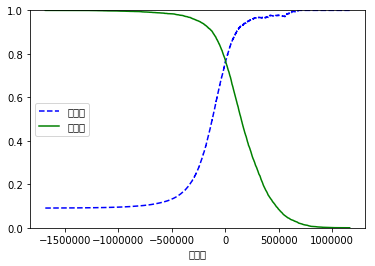

In [51]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label = "재현율")
    plt.xlabel("임계값")
    plt.legend(loc = "center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [52]:
y_train_pred_90 = (y_scores > 70000)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.8640800390434358
0.653200516509869


## ROC 곡선

ROC = TPR/FPR

TPR = recall = TP / (TP+FN)

FPR = 1 - TNR

ROC = recall / (1 - TNR)

In [53]:
from sklearn.metrics import roc_curve

fpr,tpr, thresholds = roc_curve(y_train_5, y_scores)

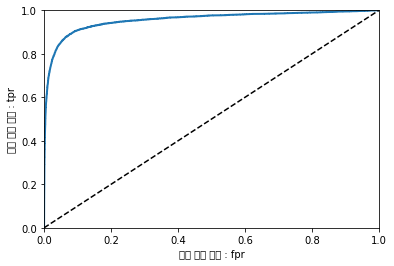

In [54]:
def plot_roc_curve(fpr,tpr, label = None):
    plt.plot(fpr,tpr, linewidth = 2, label = label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('거짓 양성 비율 : fpr')
    plt.ylabel('진짜 양성 비율 : tpr')

plot_roc_curve(fpr,tpr)
plt.show()

In [55]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_5,y_scores))

# auc값이 1에 가까울 수록 좋다.

0.9560561707541316


In [56]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

# randomForest 와 SGD를 ROC곡선으로 비교해보자.
# randomForest에는 decision function이 없다.
# 대신 확률을 나타내는 predict_proba가 있다.
# 확률을 점수로 사용해 ROC곡선을 그려보자.

In [57]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

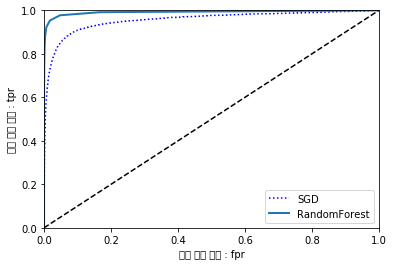

In [58]:
plt.plot(fpr,tpr, "b:", label ="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc = "lower right")
plt.show()

면적을 계산해보면 RandomForest가 더 넓으므로 좋다는 의미이다.

In [59]:
roc_auc_score(y_train_5,y_scores_forest)

0.9919280689845462

## 다중 분류

5와 5가 아닌 것을 분류하던 이진 분류기에서 더욱 다양한 것을 분류할 수 있는 다중 분류

다중 분류에는 여러 종류가 있다.

일대다(OvA) : 각각의 클래스를 구분하는 이진 분류기를 여러개 만들어 그 중 가장 점수가 높은 것을 채택하는 방식.

일대일(OvO) : 각 클래스의 조합마다 이진 분류기를 만드는 방법. N(N-1)/2개의 분류기가 필요하다.

In [62]:
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))

# sklearn 에서는 대체로 OvA 방식을 사용한다.

[5.]


In [63]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

[[-173980.97755025 -341116.24467785 -339821.94404222 -110046.41459084
  -481346.49602481  141035.52246961 -690292.52184974 -271690.65583101
  -432126.34536951 -735075.07739678]]


In [64]:
print(np.argmax(some_digit_scores))

5


In [65]:
print(sgd_clf.classes_)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [66]:
# OvO, OvA 를 강제적으로 사용할 수 있다.
# OneVsOneClassifier, OneVsRestClassifier 를 사용하면 된다.
# SGD에 OvO 방식을 적용해보자

from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter = 5, random_state = 42))
ovo_clf.fit(X_train,y_train)

print(ovo_clf.predict([some_digit]))

print(len(ovo_clf.estimators_))

[5.]
45


In [68]:
forest_clf.fit(X_train,y_train)
print(forest_clf.predict([some_digit]))
print()

# 앞서 보았듯이 randomForest는 알아서 다중분류기다.
# 각각 클래스의 확률을 받을 수 있다.

print(forest_clf.predict_proba([some_digit]))

[5.]

[[0.  0.  0.1 0.  0.  0.9 0.  0.  0.  0. ]]


##### 성능 검증

In [70]:
print(cross_val_score(sgd_clf,X_train, y_train, cv = 3, scoring = "accuracy"))

[0.84958008 0.82939147 0.83542531]


In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print(cross_val_score(sgd_clf,X_train_scaled, y_train, cv = 3, scoring = "accuracy"))

# 입력되는 data들의 scale을 균일하게 하면 더 좋은 결과를 얻을 수 있다.

[0.90866827 0.90939547 0.90908636]


## 에러 분석

In [73]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5744    2   21   11   10   38   45   10   39    3]
 [   1 6446   42   27    6   52    5   12  138   13]
 [  58   42 5320   89   78   26   90   56  179   20]
 [  43   42  133 5323    2  254   35   53  139  107]
 [  20   24   41    6 5345   11   58   33   83  221]
 [  78   38   39  174   71 4617  106   26  169  103]
 [  38   23   49    2   41   93 5605    8   58    1]
 [  22   19   67   24   56   13    5 5803   17  239]
 [  56  148   62  148   15  159   54   32 5028  149]
 [  40   30   27   87  149   35    2  191   76 5312]]


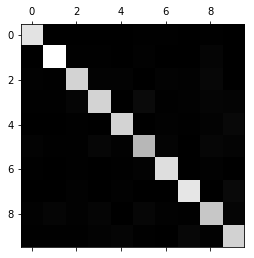

In [74]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

오차행렬을 그림으로 시각화, 대각선에 있는 것들은 옳게 판단한 경우.

색이 밝으면 해당 셀에 숫자가 크다는 의미이다.

In [75]:
row_sums = conf_mx.sum(axis = 1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

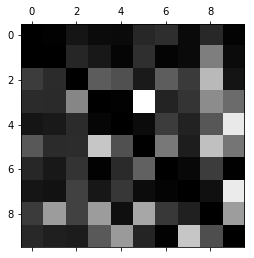

In [76]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [94]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

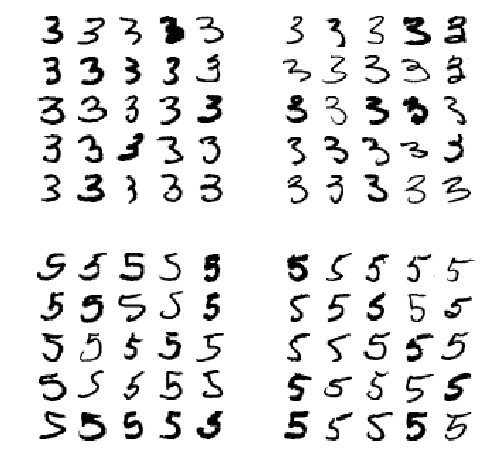

In [79]:
cl_a,cl_b = 3,5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

## 다중 레이블 분류

y값을 한개만 출력했지만, 이제는 여러 개의 y값을 출력한다.

In [80]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [81]:
print(knn_clf.predict([some_digit]))

[[False  True]]


In [84]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3, n_jobs = -1)

print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

# 이 경우는 모든 레이블의 가중치가 같다고 가정한 경우이다. 가중치를 주려면 average="weight"라고 하면 된다.

0.9768380069988081


## 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 한 것이다.

ex) [1,0,1] 으로 0,1 의 이진분류를 하던 다중 레이블 분류! 하지만 이제 [1,2,3] 등 0,1,2,3의 다중 분류가 가능해졌다!


In [100]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

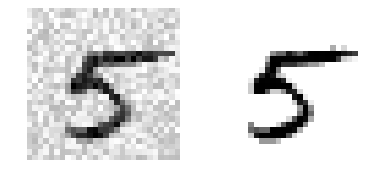

In [102]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

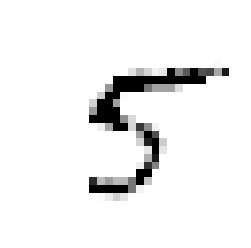

In [104]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)